# PyFinPO - User Guide

The present notebook provides a practical guide of some of the basic functionalities of PyPO, and how to use the library to perform portfolio optimization on a given set of provided inputs.

# Overview of Portfolio Optimization in PyFinPO

Portfolio Optimization is a complex problem, which we will try to address following the methodology depicted in the below Figure.



The steps that we're going to cover are the following:  
<br>

0) [Source Data](#0-source-data)  
<br>
1) [Input Estimates](#1-input-estimates)

    - 1.1) [Expected Return Models](#11-expected-return-models)

    - 1.2) [Risk Models](#12-risk-models)
    
    - 1.3) [Robust Models](#13-robust-models)  
<br>
2) [Portfolio Optimization](#2-portfolio-optimization)

    - 2.1) [Portfolio Optimization Model](#21-portfolio-optimization-model)

    - 2.2) [Portfolio Optimization Objective Function](#22-portfolio-objective-function)

    - 2.3) [Portfolio (Custom) Optimization Objectives](#23-portfolio-custom-optimization-objectives)

    - 2.4) [Portfolio Constraints](#24-portfolio-optimization-constraints)

    - 2.5) [Portfolio Optimization Period](#25-portfolio-optimization-period)

    - 2.6) [Portfolio Optimization Solver](#26-portfolio-optimization-solver-optimizer)  
<br>
3) [Portfolio Performance](#3-portfolio-performance) 

    - 3.1) [Portfolio Tidy Weights](#31-see-portfolio-tidy-weights)

    - 3.2) [Portfolio Performance](#32-portfolio-optimization-performance)

    - 3.3) [Portfolio Discrete Allocation](#33-portfolio-discrete-allocation)


## 0) Source Data

### Basic Imports

Although in each of the blocks the necessary imports will be declared again, this is an overview of all the imports that we will use throughout this guide:

In [6]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

sys.path.append('/Users/alvarosanchez/Documents/Projects/personal-projects/pypot')
from pypo.input_estimates import expected_return_models
from pypo.input_estimates import risk_models
from pypo.input_estimates.robust_models import black_litterman_rm, BlackLittermanModel
from pypo.portfolio_optimization import po_models
from pypo.portfolio_performance import portfolio_performance
from pypo.utils import DiscreteAllocation, get_latest_prices
from pypo.visualization import po_plotting

### Getting Data

In [7]:
import yfinance as yf

tickers = ["AAPL", "META", "AMZN", "NFLX", "GOOG", "GS", "JPM", "MS", "C", "MSFT", "PFE", "TSLA", "UNH", "XOM"]
ohlc = yf.download(tickers, start="2000-01-01")
prices = ohlc["Adj Close"].dropna(how="all")

[*********************100%***********************]  14 of 14 completed


In [3]:
prices

Ticker,AAPL,AMZN,C,GOOG,GS,JPM,META,MS,MSFT,NFLX,PFE,TSLA,UNH,XOM
Date,,,,,,,,,,,,,,
2000-01-03 00:00:00+00:00,0.843076,4.468750,213.532455,NaN,62.921883,23.501028,NaN,33.783863,35.935841,NaN,12.493900,NaN,5.358777,17.888824
2000-01-04 00:00:00+00:00,0.771997,4.096875,200.438416,NaN,58.958641,22.985376,NaN,31.281359,34.721939,NaN,12.028438,NaN,5.290235,17.546175
2000-01-05 00:00:00+00:00,0.783293,3.487500,208.496323,NaN,56.197750,22.843479,NaN,30.139587,35.088043,NaN,12.224419,NaN,5.277773,18.502726
2000-01-06 00:00:00+00:00,0.715508,3.278125,218.568481,NaN,58.602390,23.167799,NaN,30.718281,33.912666,NaN,12.665384,NaN,5.470937,19.459270
2000-01-07 00:00:00+00:00,0.749402,3.478125,217.561279,NaN,58.825062,23.593451,NaN,31.672363,34.355835,NaN,13.522807,NaN,6.112745,19.402164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-11 00:00:00+00:00,224.229996,206.839996,69.800003,181.970001,602.340027,239.289993,583.169983,133.520004,418.010010,805.440002,26.240000,350.000000,625.250000,119.488152
2024-11-12 00:00:00+00:00,224.229996,208.910004,69.019997,183.320007,592.590027,239.559998,584.820007,132.309998,423.029999,819.500000,26.190001,328.489990,614.669983,119.369125
2024-11-13 00:00:00+00:00,225.119995,214.100006,68.889999,180.490005,594.219971,241.160004,580.000000,132.759995,425.200012,830.469971,26.719999,330.239990,605.869995,120.480003


### Splitting Data in 2 datasets (past and future)

In [8]:
prices_past = prices.iloc[:5031]
prices_future = prices.iloc[5031:]

prices_past
prices_future

Ticker,AAPL,AMZN,C,GOOG,GS,JPM,META,MS,MSFT,NFLX,PFE,TSLA,UNH,XOM
Date,,,,,,,,,,,,,,
2020-01-02 00:00:00+00:00,72.796021,94.900497,67.122940,68.201012,208.356293,122.104591,209.150269,44.275696,153.938217,329.809998,29.978146,28.684000,272.817535,55.631195
2020-01-03 00:00:00+00:00,72.088280,93.748497,65.858643,67.866325,205.919907,120.493256,208.043610,43.561024,152.021393,325.899994,29.817297,29.534000,270.056641,55.183933
2020-01-06 00:00:00+00:00,72.662712,95.143997,65.652061,69.539726,208.027313,120.397438,211.961823,43.407867,152.414368,335.829987,29.779013,30.102667,271.931396,55.607643
2020-01-07 00:00:00+00:00,72.320984,95.343002,65.081902,69.496330,209.396667,118.350632,212.420425,43.322792,151.024658,330.750000,29.679432,31.270666,270.289886,55.152534
2020-01-08 00:00:00+00:00,73.484337,94.598503,65.577690,70.043991,211.415115,119.273888,214.573944,43.875813,153.430298,339.260010,29.916864,32.809334,275.988708,54.320816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-11 00:00:00+00:00,224.229996,206.839996,69.800003,181.970001,602.340027,239.289993,583.169983,133.520004,418.010010,805.440002,26.240000,350.000000,625.250000,119.488152
2024-11-12 00:00:00+00:00,224.229996,208.910004,69.019997,183.320007,592.590027,239.559998,584.820007,132.309998,423.029999,819.500000,26.190001,328.489990,614.669983,119.369125
2024-11-13 00:00:00+00:00,225.119995,214.100006,68.889999,180.490005,594.219971,241.160004,580.000000,132.759995,425.200012,830.469971,26.719999,330.239990,605.869995,120.480003


## 1) Input Estimates

Once the data relative to all the universe of securities has been sourced (either closing prices or in daily returns format), we need to provide estimates of the parameters that we want to maximize/minimize in the portfolio optimization.

The specific parameters to be optimized will depend on the portfolio optimization model and objective function of choice (which we will cover later on). However, almost all portfolio optimization models use a metric of return and a metric of risk as optimization paraters. Therefore, it is a safe assumption that most portfolio optimization models will need estimates for 2 main types of inputs:

- An estimate for the expected returns of the investment universe
- An estimate for the riskiness of each asset in the investment universe. The measure of risk chosen can vary depending on the portfolio optimization model, but most common measures can be calculated from the covariance matrix (which measures variance of returns between all of the assets the investment universe).

### 1.1) Expected Return Models

Providing good estimates of asset returns is one of the most important parts of the portfolio optimization process. The objective here is, based on the historical data of prices/returns of all the investable assets, to estimate the future expected return for each of them during the investment horizon that is subject to optimization.

A good portfolio optimization requires of a good proprietary method to properly forecast expected returns as accurately as possible. PyPO library provides 3 basic models (sourced from [PyPortOpt](https://pyportfolioopt.readthedocs.io/en/latest/ExpectedReturns.html)) to forecast expected returns:
 - ``mh_rm`` -> Mean Historical Return Model 
 - ``ewmh_rm`` -> Exponentially Weighted Mean Historical Return Model 
 - ``capm_rm`` -> Capital Asset Pricing Model 

*Note: Future extensions of the PyPO library will focus on expanding the expected return predictive models to include main models suggested in research such as Time-Series Forecasting (ARIMA, GARCH...), Vector Autoregressive Models, or more advanced Machine Learning forecasting models.*

We can implement the aforementioned expected return models as follows:

In [3]:
import sys

sys.path.append('/Users/alvarosanchez/Documents/Projects/personal-projects/pypot')

In [9]:
from pypo.input_estimates import expected_return_models

mhr = expected_return_models.mh_rm(prices)
ewmhr = expected_return_models.ewmh_rm(prices)
capmr = expected_return_models.capm_rm(prices)

We can also compare how each of these models predicted the returns of the ``future_prices`` dataset, based only on the ``past_prices`` input dataset:

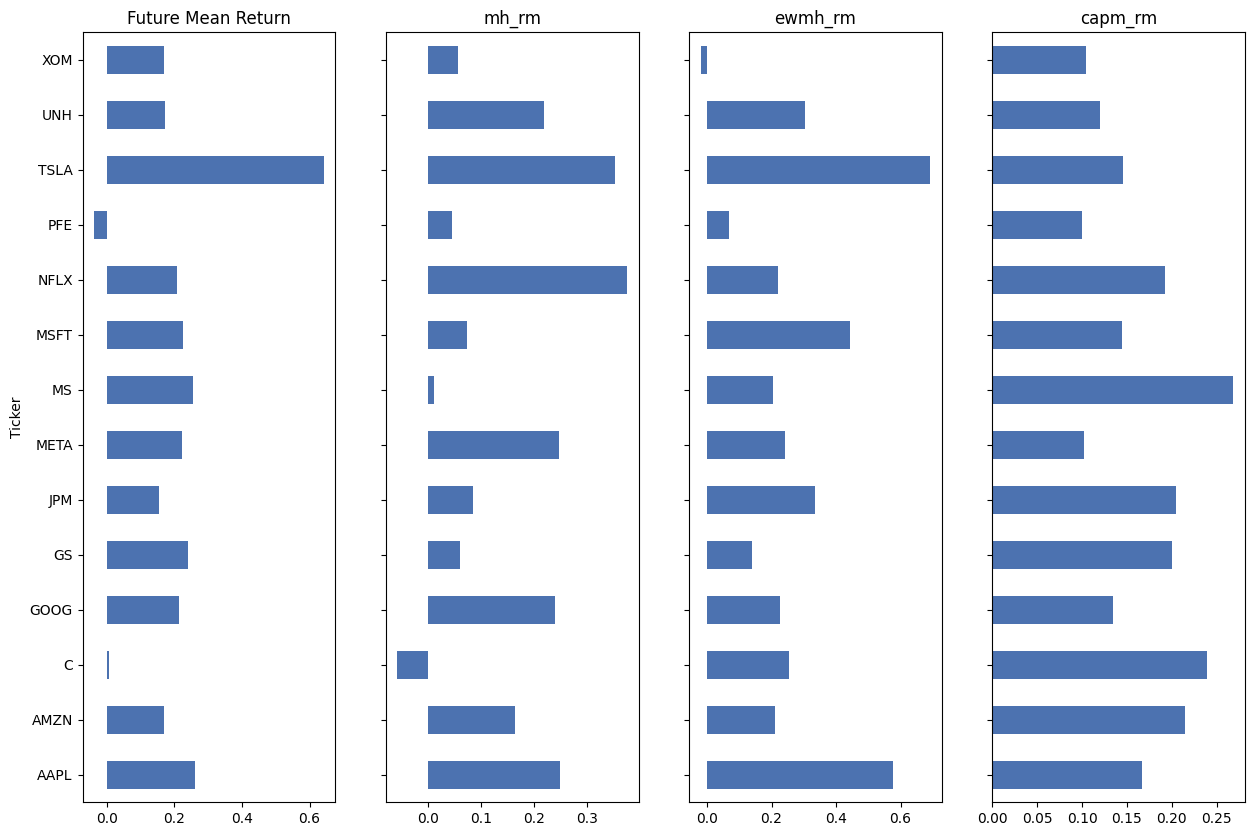

In [7]:
import matplotlib.pyplot as plt

mu_future = expected_return_models.mh_rm(prices_future)

return_methods = [
    "mh_rm",
    "ewmh_rm",
    "capm_rm",
    ]

fig, axs = plt.subplots( 1, len(return_methods)+1,sharey=True, figsize=(15,10))

axs[0].set_title("Future Mean Return")
mu_future.plot.barh(ax=axs[0])

for i, method in enumerate(return_methods):
    mu = expected_return_models.compute_expected_return(prices_past, method=method)
    axs[i+1].set_title(method)
    mu.plot.barh(ax=axs[i+1])

### 1.2) Risk Models

Same as with the return models, we will also need to provide a risk model as input for the portfolio optimization. In this case, and although many different risk metrics can be chosen as objective for optimization, most portfolio optimization models will only need as input for risk an estimate for the covariance matrix of all the assets in the investment universe.

As exposed in [[1](https://pyportfolioopt.readthedocs.io/en/latest/RiskModels.html)], risk models are often more important than expected return models because historical variance is generally a much more persistent statistic than mean historical returns. In fact, research by [Kritzman et al. (2010)](https://www.jstor.org/stable/27809177) suggests that minimum variance portfolios, formed by optimising without providing expected returns, actually perform much better out of sample.

In order to estimate the covariance matrix, several estimators are proposed in the PyPO library (sourced from [PyPortOpt](https://pyportfolioopt.readthedocs.io/en/latest/RiskModels.html)):
- ``sample_cov`` - Sample Covariance Estimation
- ``semi_cov`` - SemiCovariance Estimation
- ``ew_cov`` - Exponentially Weighted Covariance Estimation
- ``CovarianceShrinkage`` - Provide more robust estimations of the covariance matrix

We can implement the aforementioned expected return models as follows:

In [10]:
from pypo.input_estimates import risk_models

future_cov = risk_models.sample_cov(prices_future)

In [11]:
sample_cov = risk_models.sample_cov(prices_past)
semi_cov = risk_models.semi_cov(prices_past)
ew_cov = risk_models.ew_cov(prices_past)
ledoit_cov = risk_models.CovarianceShrinkage(prices_past).ledoit_wolf()

We can also plot the calculated covariance estimations and compare them with the real future covariance matrix, in order to observe which covariance estimator performs best.

Comparing the sample covariance vs the future covariance matrix, we observe how ``sample_cov`` consistently underestimates the covariance between assets in the lower part of the covariance matrix, such as ``NFLX`` vs ``META``, ``PFL`` vs ``META``, or ``TSL`` vs most other assets. In the future covariance matrix, we can see how the real covariances are actually higher than predicted (clearer colors).

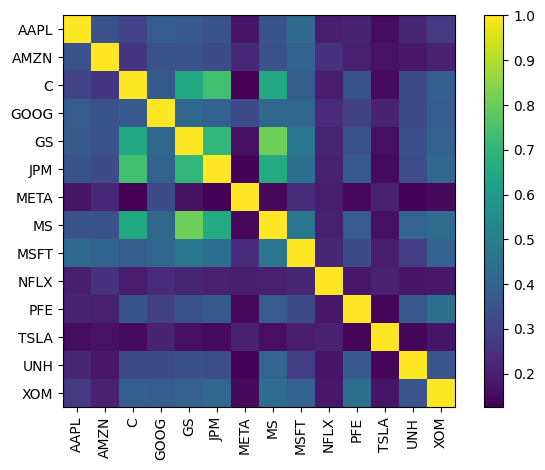

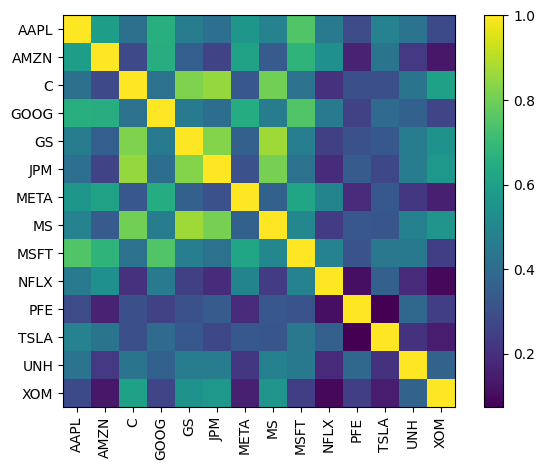

In [10]:
from pypo.visualization import po_plotting

po_plotting.plot_covariance(sample_cov, plot_correlation=True)
po_plotting.plot_covariance(future_cov, plot_correlation=True)
plt.show()

Executing the same comparison with other estimators for the covariance matrix, we can see how the exponentially weighted covariance matrix ``ew_cov`` seems to be a better estimator of future variance than the sample covariance matrix:

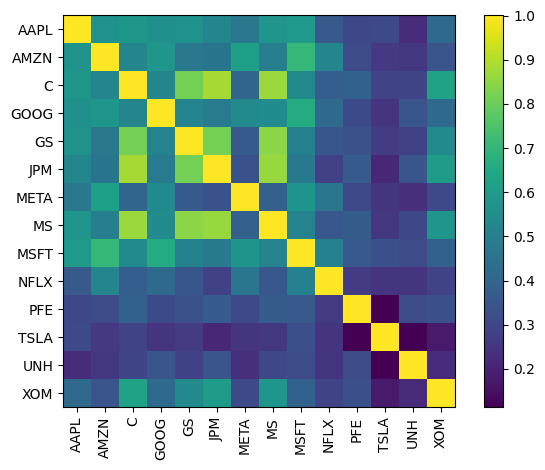

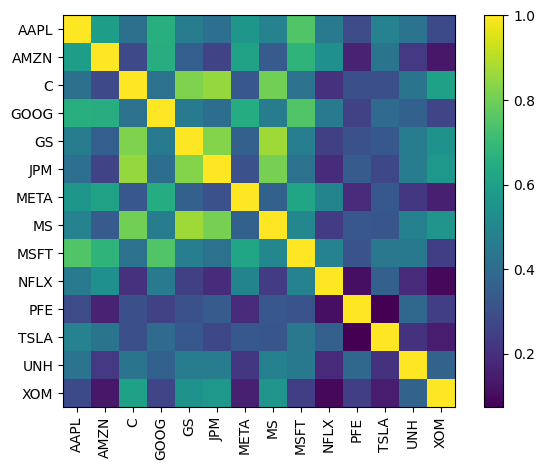

In [11]:
po_plotting.plot_covariance(ew_cov, plot_correlation=True)
po_plotting.plot_covariance(future_cov, plot_correlation=True)
plt.show()

We can compare visually the performance of all the covariance estimators based on their mean absolute error (less is better):

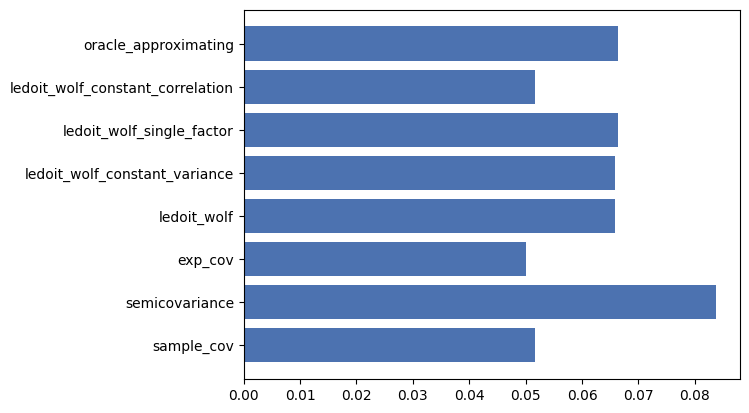

In [12]:
import numpy as np

future_variance = np.diag(future_cov)
mean_abs_errors = []

risk_methods = [
    "sample_cov",
    "semicovariance",
    "exp_cov",
    "ledoit_wolf",
    "ledoit_wolf_constant_variance",
    "ledoit_wolf_single_factor",
    "ledoit_wolf_constant_correlation",
    "oracle_approximating",
]

for method in risk_methods:
    S = risk_models.compute_risk_matrix(prices, method=method)
    variance = np.diag(S)
    mean_abs_errors.append(np.sum(np.abs(variance - future_variance)) / len(variance))
    
xrange = range(len(mean_abs_errors))
plt.barh(xrange, mean_abs_errors)
plt.yticks(xrange, risk_methods)
plt.show()

### 1.3) Robust Models

PyPO library also provides the option to select robust models as inputs for the portfolio optimization. These models lie in between return and risk models, as they have their own methodology and provide more robust estimates for both return and risk.  
The main robust model currently implemented is the Black-Litterman model, which is further explained in the docs. The notebook ``2-BL-CVaR-PO.ipynb`` provides an sample case study of how to implement a Black-Litterman optimization, which in a nutshell can be coded as follows:

In [13]:
from pypo.input_estimates.robust_models import black_litterman_rm, BlackLittermanModel

viewdict = {"AAPL": 0.20, "AMZN": -0.30, "MS": 0, "MSFT": -0.2, "TSLA": 0.15}
bl = BlackLittermanModel(sample_cov, absolute_views=viewdict)

/Users/alvarosanchez/Documents/Projects/personal-projects/pypot/pypo/input_estimates/robust_models/black_litterman_rm.py:266: UserWarning: Running Black-Litterman with no prior.
  warnings.warn("Running Black-Litterman with no prior.")


## 2) Portfolio Optimization

Once the input estimates have been determined, we can proceed with the portfolio optimization process.

### 2.1) Portfolio Optimization Model

The first step of the portfolio optimization is to choose the optmization model/framework. The portfolio optimization model of choice is going to determine the type of approach we want for the portfolio optimization, the different objective functions that we will be able to optimize for, and the solver used to approach the optimization problem, among other things. As we will see later on, each optimization model/framework has its particular objective functions and solvers/optimizers.

The following Portfolio Optimization Models are supported:
- **Mean-Variance Portfolio Optimization** (MVPO) (Efficient Frontier)

- **Mean-SemiVariance Portfolio Optimization** (MSVPO) (Semi-Efficient Frontier)

- **Mean-CVaR (Conditional Value at Risk) Portfolio Optimization** (MCVaRPO) (Efficient CVaR Frontier)

- **Mean-CDaR (Conditional Drawdown at Risk) Portfolio Optimization** (MCDaRPO) (Efficient CDaR Frontier)

- **Critial Line Algorithm Portfolio Optimization** (CLAPO)  (Efficient Derivation of Efficient Frontier)

- **Hierarchical Risk Parity Portfolio Optimization** (HRPPO) (Efficient Hierarchical Clustering)

In this first example we will mostly use Mean-Variance theory, as it is the most extended model for portfolio optimization. The following code allows to initialize a mean-variance object for construction of a long-short portfolio with the inputs calculated in the previous sections (expected return and covariance matrix).

In [ ]:
from pypo.portfolio_optimization import po_models

mv_po = po_models.MeanVariancePO(expected_returns=mhr, cov_matrix=sample_cov, weight_bounds=(-1,1), verbose=True)

Conversely, this is how you can initialize the different portfolio optimization models implemented in PyPO (sourced from [PyPortOpt](https://pyportfolioopt.readthedocs.io/en/latest/index.html)):

In [ ]:
from pypo.portfolio_optimization import po_models

msv_po = po_models.MeanSemivariancePO(expected_returns=mhr, returns=prices_past, weight_bounds=(-1,1), verbose=True)
mcvar_po = po_models.MeanCVaRPO(expected_returns=mhr, returns=prices_past, weight_bounds=(-1,1), verbose=True)
mcdar_po = po_models.MeanCDaRPO(expected_returns=mhr, returns=prices_past, weight_bounds=(-1,1), verbose=True)
cla_po = po_models.CLAPO(expected_returns=mhr, cov_matrix=sample_cov, weight_bounds=(-1,1))
hrp_po = po_models.HRPPO(returns=prices_past, cov_matrix=sample_cov)

/Users/alvarosanchez/Documents/Projects/personal-projects/pypot/pypo/portfolio_optimization/po_models/mv_po.py:160: UserWarning: Removing NaNs from returns
  warnings.warn(
/Users/alvarosanchez/Documents/Projects/personal-projects/pypot/pypo/portfolio_optimization/po_models/mv_po.py:160: UserWarning: Removing NaNs from returns
  warnings.warn(
/Users/alvarosanchez/Documents/Projects/personal-projects/pypot/pypo/portfolio_optimization/po_models/mv_po.py:160: UserWarning: Removing NaNs from returns
  warnings.warn(


### 2.2) Portfolio Objective Function

Once the mean-variance framework object is initialized, the next step is to choose an objective function to optimize for. Mean-variance allows for different types of optimization targets, depending on the point in the efficient frontier that we want for our portfolio:

- **Minimum Volatility**
    - This is the point in the efficient frontier that minimizes variance, for whatever level of return. Although it may not seem to make much sense to optimize for the Global Minimum Variance (GMV) Portfolio, research suggests that GMV portfolios can consistently outperform return-risk optimal portfolios when the expected returns estimates are not accurate (i.e. when we don't have a proper predictive model to forecast returns).
- **Efficient Risk**
    - This is the portfolio that maximizes return for a given target risk.
- **Efficient Return**
    - This is the portfolio that maximizes risk for a given target of return. This is also known as the Markowitz portfolio.
- **Maximum Sharpe Ratio** _(only recommended if using a good model for predicting returns)_
    - This results in a _tangency portfolio_ because on a graph of returns vs risk, this portfolio corresponds to the tangent of the efficient frontier that has a y-intercept equal to the risk-free rate. This is the default option because it finds the optimal return per unit risk.
- **Maximum Quadratic Utility**
    - Allows to provide your own risk-aversion level and compute the subsequent optimal portfolio.

_Note: not all the Portfolio Optimization Models support all the above objective functions._ [_See details here_](https://pyportfolioopt.readthedocs.io/en/latest/GeneralEfficientFrontier.html).

<center>
<img src="https://github.com/robertmartin8/PyPortfolioOpt/blob/master/media/efficient_frontier_white.png?raw=true" style="width:60%;"/>
</center>

The below code shows how to obtain the optimized portfolio weights (opw) for each of the aforementioned objectives. Note that in order to compute the weigths, we need to use a new instance of MeanVariancePO (we can only solve one problem for a given MeanVariancePO object).

In [ ]:
mv_po1 = po_models.MeanVariancePO(expected_returns=mhr, cov_matrix=sample_cov, weight_bounds=(-1,1), verbose=True)
mv_po2 = po_models.MeanVariancePO(expected_returns=mhr, cov_matrix=sample_cov, weight_bounds=(0,1), verbose=True)
mv_po3 = po_models.MeanVariancePO(expected_returns=mhr, cov_matrix=sample_cov, weight_bounds=(-1,1), verbose=True)
mv_po4 = po_models.MeanVariancePO(expected_returns=mhr, cov_matrix=sample_cov, weight_bounds=(-1,1), verbose=True)
mv_po5 = po_models.MeanVariancePO(expected_returns=mhr, cov_matrix=sample_cov, weight_bounds=(-1,1), verbose=True)

In [ ]:
mv_opw = mv_po1.min_volatility() # Finds GMV portfolio
erisk_opw = mv_po2.efficient_risk(target_volatility=0.20) # Maximizes return for target risk
eret_opw = mv_po3.efficient_return(target_return=0.1) # Minimizes risk for target return
ms_opw = mv_po4.max_sharpe() # Maximizes return/risk ratio (finds tangency portfolio)
mu_opw = mv_po5.max_quadratic_utility(risk_aversion=1) # Maximizes personal investor utility function


                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Nov 15 10:47:39 AM: Your problem has 14 variables, 29 constraints, and 0 parameters.


(CVXPY) Nov 15 10:47:39 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 15 10:47:39 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 15 10:47:39 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 15 10:47:39 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 15 10:47:39 AM: Compiling problem (target solver=OSQP).
(CVXPY) Nov 15 10:47:39 AM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> OSQP
(CVXPY) Nov 15 10:47:39 AM: Applying reduction CvxAttr2Constr
(CVXPY) Nov 15 10:47:39 AM: Applying reduction Qp2SymbolicQp
(CVXPY) Nov 15 10:47:39 AM: 

### 2.3) Portfolio (Custom) Optimization Objectives

The previously introduced portfolio objective functions are straight-forward to compute, and produce a weight allocation when calling their respective methods. However, sometimes we may want to add extra optimization objectives that are not defined in the previous 5 objective functions.

It is possible to add extra objectives using the methodology described below. Note that there are 2 types of optimization objectives, convex and non-convex. While convex objectives fit nicely under a convex optimization solver like the one (described in section 2.6), non-convex objectives may be treated with care as they may produce incompatibilitys with the solvers implemented in this library.

- **Convex Objectives:**
    - L2 regularisation (minimising this reduces nonzero weights)
    - Transaction cost model
    - Custom convex objectives (must be expressed with ``cvxpy`` [atomic functions](https://www.cvxpy.org/tutorial/functions/index.html))
    
- **Non-Convex Objectives:**
    - See example in the original docs of the PyPortOpt library [here](https://github.com/robertmartin8/PyPortfolioOpt/blob/master/cookbook/3-Advanced-Mean-Variance-Optimisation.ipynb)

#### Example of L2 Regularization

For instance, let's imagine that we have performed a the mean-variance portfolio optimization ``mv_po2`` described in the previous section, and we have obtained the following portfolio optimal weights that maximize return for a target variance of 20%:

In [ ]:
erisk_opw

OrderedDict([('AAPL', np.float64(0.0880821087540093)),
             ('AMZN', np.float64(1.0088981e-09)),
             ('C', np.float64(1.73412e-10)),
             ('GOOG', np.float64(0.1530765942079676)),
             ('GS', np.float64(9.51168e-10)),
             ('JPM', np.float64(9.202726e-10)),
             ('META', np.float64(0.1673418028466406)),
             ('MS', np.float64(1.764496e-10)),
             ('MSFT', np.float64(8.5899906e-09)),
             ('NFLX', np.float64(0.0364087012155675)),
             ('PFE', np.float64(0.0733846268236002)),
             ('TSLA', np.float64(0.12169842309745)),
             ('UNH', np.float64(0.1970396459212819)),
             ('XOM', np.float64(0.162968085313292))])

While this portfolio should meet our objectives, we may be concerned about the lack of diversification (there are up to 6 stocks which have 0 weights: ``AMZN``, ``C``,``GS``,``JPM``,``MS``,``MSFT``). We can enforce a higher level of diversification with L2 regularization (i.e. adding a penalty on the number of quasi-zero weights):

In [ ]:
from pypo.portfolio_optimization.po_objective_functions import objective_functions
# We need to create a new MeanVariancePO object first
mv_po2b = po_models.MeanVariancePO(expected_returns=mhr, cov_matrix=sample_cov, weight_bounds=(0,1), verbose=True)
mv_po2b.add_objective(objective_functions.L2_reg, gamma=0.1)
erisk_opw2 = mv_po2b.efficient_risk(target_volatility=0.20) # Maximizes return for target risk
erisk_opw2

                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Nov 15 11:00:52 AM: Your problem has 14 variables, 30 constraints, and 1 parameters.
(CVXPY) Nov 15 11:00:52 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 15 11:00:52 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 15 11:00:52 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 15 11:00:52 AM: Compiling problem (target solver=CLARABEL).
(CVXPY) Nov 15 11:00:52 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> CLARABEL
(CVXPY) Nov 15 11:00:52 A

OrderedDict([('AAPL', np.float64(0.0935255457538243)),
             ('AMZN', np.float64(2.0948743e-09)),
             ('C', np.float64(1.543017e-10)),
             ('GOOG', np.float64(0.1435205181241284)),
             ('GS', np.float64(2.076641e-09)),
             ('JPM', np.float64(1.4016321e-09)),
             ('META', np.float64(0.1563921278824029)),
             ('MS', np.float64(1.473157e-10)),
             ('MSFT', np.float64(0.0318837112916811)),
             ('NFLX', np.float64(0.0466996119373911)),
             ('PFE', np.float64(0.0922563723357902)),
             ('TSLA', np.float64(0.1249911114301388)),
             ('UNH', np.float64(0.1744528474742458)),
             ('XOM', np.float64(0.1362781478956332))])

We can see how after regularization, ``MSFT`` has been allocated a non-zero weight.
We can play with the ``gamma`` factor to adjust the number of zero weights that we want in our portfolio:

In [ ]:
from pypo.portfolio_optimization.po_objective_functions import objective_functions
# We need to create a new MeanVariancePO object first
mv_po2b = po_models.MeanVariancePO(expected_returns=mhr, cov_matrix=sample_cov, weight_bounds=(0,1), verbose=True)
mv_po2b.add_objective(objective_functions.L2_reg, gamma=1)
erisk_opw2 = mv_po2b.efficient_risk(target_volatility=0.20) # Maximizes return for target risk
erisk_opw2

                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Nov 15 11:03:34 AM: Your problem has 14 variables, 30 constraints, and 1 parameters.
(CVXPY) Nov 15 11:03:34 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 15 11:03:34 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 15 11:03:34 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 15 11:03:34 AM: Compiling problem (target solver=CLARABEL).
(CVXPY) Nov 15 11:03:34 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> CLARABEL
(CVXPY) Nov 15 11:03:34 A

OrderedDict([('AAPL', np.float64(0.0870948524662957)),
             ('AMZN', np.float64(0.0175341154652774)),
             ('C', np.float64(2.111078e-10)),
             ('GOOG', np.float64(0.114776838862146)),
             ('GS', np.float64(0.0293845150929148)),
             ('JPM', np.float64(0.0259957575344174)),
             ('META', np.float64(0.1310226641791422)),
             ('MS', np.float64(1.979833e-10)),
             ('MSFT', np.float64(0.0689515608821474)),
             ('NFLX', np.float64(0.0569839718606788)),
             ('PFE', np.float64(0.1055507568743195)),
             ('TSLA', np.float64(0.1115202815650925)),
             ('UNH', np.float64(0.1332606546629454)),
             ('XOM', np.float64(0.1179240301455318))])

For further examples on how to add custom objectives to the optimization, visit [the cookbook](https://github.com/robertmartin8/PyPortfolioOpt/blob/master/cookbook/2-Mean-Variance-Optimisation.ipynb) provided by the original docs of the PyPortOpt library.

### 2.4) Portfolio Optimization Constraints

Constraints and objectives are treated similarly from an optimization point of view. Therefore, the methodology to add constraints to a portfolio optimization is very similar to the process of adding objectives described above. The main portfolio optimization constraints which can be implemented are:
 
 - **Market Neutrality**

 - **Long/Short Portfolio**
 
 - **Weight Bounds** (limit the position size of securities)
 
 - **Sector & Security Constraints**
 
 - **Score Constraints**

 - **Nº of Asset Constraints** (Convexity Constraints)

 - **Tracking Error Constraints**

#### Market Neutrality

When defining certain objective functions, it is possible to specify the option ``market_neutral=True`` to form a market-neutral portfolio (i.e weights sum to zero). This is not possible for the max Sharpe portfolio and the min volatility portfolio because in those cases because they are not invariant with respect to leverage. Market neutrality requires negative weights:

In [ ]:
market_neutral_po1 = po_models.MeanVariancePO(mhr, sample_cov, weight_bounds=(-1,1))
market_neutral_po2 = po_models.MeanVariancePO(mhr, sample_cov, weight_bounds=(-1,1))
market_neutral_po3 = po_models.MeanVariancePO(mhr, sample_cov, weight_bounds=(-1,1))

market_neutral_po1.efficient_risk(target_volatility=0.2, market_neutral=True)
market_neutral_po2.efficient_return(target_return=0.2, market_neutral=True)
market_neutral_po3.max_quadratic_utility(risk_aversion=1, market_neutral=True)

OrderedDict([('AAPL', np.float64(0.7293008092708207)),
             ('AMZN', np.float64(-0.1627648368325332)),
             ('C', np.float64(-1.0)),
             ('GOOG', np.float64(1.0)),
             ('GS', np.float64(-0.2772522791607433)),
             ('JPM', np.float64(0.446932427897695)),
             ('META', np.float64(0.1700845215533746)),
             ('MS', np.float64(-0.1371972276347609)),
             ('MSFT', np.float64(-1.0)),
             ('NFLX', np.float64(0.4332355776742808)),
             ('PFE', np.float64(-1.0)),
             ('TSLA', np.float64(1.0)),
             ('UNH', np.float64(0.7976610072318663)),
             ('XOM', np.float64(-1.0))])

#### Long/Short Portfolio

We can choose to create long-only or long-short portfolios, by specifying the desired ``weight_bounds``when instanciating the ``MeanVarianceO``object (or the portfolio optimization model of choice). Introducing ``weight_bounds=(-1,1)`` –or no bounds whatsoever: ``weight_bounds=(None,None)``– enables the creation of long-short portfolios:

In [ ]:
long_only_po = po_models.MeanVariancePO(mhr, sample_cov, weight_bounds=(0,1))
long_short_po = po_models.MeanVariancePO(mhr, sample_cov, weight_bounds=(-1,1))
long_short_po = po_models.MeanVariancePO(mhr, sample_cov, weight_bounds=(None,None))

#### Weight Bounds

Imagine that you don't want any security to account for more than 15% of the total portfolio. This can be easily implemented with the parameter ``weight_bounds``:

In [ ]:
limited_size_po = po_models.MeanVariancePO(mhr, sample_cov, weight_bounds=(0,0.15))

#### Sector and Securities Constraints

Many times it is the case that you don't want to invest more than a certain amount of your portfolio in certain sectors or specific securities.

Sector constraints can be implemented as follows, using 3 inputs: a ``security_sector_map``, and your ``sector_lower_bounds`` and ``sector_upper_bounds``:

In [ ]:
security_sector_map = {
    "AMZN": "Consumer Discretionary",
    "C": "Tech",
    "GOOG": "Tech",
    "GS": "Financial Services",
    "JPM": "Financial Services",
    "Meta": "Tech",
    "MS": "Financial Services",
    "MSFT": "Tech",
    "NFLX": "Communication Services",
    "PFE": "Healthcare",
    "TSLA": "Auto",
    "UNH": "Healthcare",
    "XOM": "Energy"
}

sector_lower_bounds = {
    "Financial Services": 0.03, # at least 3% to Financial Services
    "Tech": 0.05 # at least 5% to Tech
    # For all other sectors, it will be assumed there is no lower bound
}

sector_upper_bounds = {
    "Tech": 0.2,
    "Energy": 0.1,
    "Auto":0.15
}

Constraints on specific securities can also be added following two steps: i) adding the security ticker to the internal index of the library, and ii) defining the specific bound. The following example combines both sector and security constraints:

In [ ]:
constrained_po = po_models.MeanVariancePO(mhr, sample_cov, weight_bounds=(0,1))

# Adding sector constraints previously defined:
constrained_po.add_sector_constraints(security_sector_map, sector_lower_bounds, sector_upper_bounds)

amzn_index = constrained_po.tickers.index("AMZN")
constrained_po.add_constraint(lambda w: w[amzn_index] == 0.07) # Assigns exactly 10% of the portfolio to Amazon

tsla_index = constrained_po.tickers.index("TSLA")
constrained_po.add_constraint(lambda w: w[tsla_index] >= 0.01) # Assigns more than 5% of the portfolio to Tesla

meta_index = constrained_po.tickers.index("META")
constrained_po.add_constraint(lambda w: w[meta_index] <= 0.05) # Assigns less than 3% of the portfolio to META


opw_cpo = constrained_po.max_sharpe()
opw_cpo

OrderedDict([('AAPL', np.float64(0.1344084488591732)),
             ('AMZN', np.float64(0.07)),
             ('C', np.float64(0.0)),
             ('GOOG', np.float64(0.2)),
             ('GS', np.float64(0.0046415148219269)),
             ('JPM', np.float64(0.0253584851780731)),
             ('META', np.float64(0.05)),
             ('MS', np.float64(0.0)),
             ('MSFT', np.float64(0.0)),
             ('NFLX', np.float64(0.1017765767956572)),
             ('PFE', np.float64(0.0)),
             ('TSLA', np.float64(0.15)),
             ('UNH', np.float64(0.2638149743451697)),
             ('XOM', np.float64(0.0))])

<Axes: >

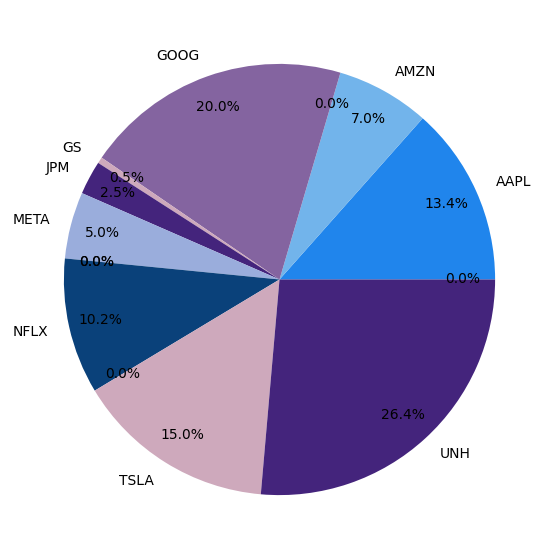

In [ ]:
colors = ['#2085ec', '#72b4eb', '#0a417a', '#8464a0', '#cea9bc', '#44247c', '#9aaddc']

pd.Series(opw_cpo).plot.pie(figsize=(7,7), colors=colors, autopct='%1.1f%%', pctdistance=0.85)

#### Score Constraints

Imagine you have a "score" for each asset—this could be an ESG metric or a custom risk/return measure. Setting linear constraints is straightforward; for example, if you want the portfolio's ESG score to exceed a certain threshold ``x``, you can create a vector of scores and impose a constraint on the dot product of these scores with the portfolio weights. After that, you can proceed to optimize your objective.

In [ ]:
esg_scores = [0.3, 0.1, 0.5, 0.1, 0.4, 0.1, 0.9, 0.20, 0.1, 0.4, 0.1, 0.5, 0.9, 0.2]
portfolio_min_score = 0.5

scores_const_po = po_models.MeanVariancePO(mhr, sample_cov)
scores_const_po.add_constraint(lambda w: esg_scores @ w >= portfolio_min_score)
scores_const_po.min_volatility()

OrderedDict([('AAPL', np.float64(0.043110058368738)),
             ('AMZN', np.float64(0.0)),
             ('C', np.float64(0.0)),
             ('GOOG', np.float64(0.0008607599273448)),
             ('GS', np.float64(0.0048537664391726)),
             ('JPM', np.float64(0.0)),
             ('META', np.float64(0.2104300643544425)),
             ('MS', np.float64(0.0)),
             ('MSFT', np.float64(0.0293947848410581)),
             ('NFLX', np.float64(0.0013954893932988)),
             ('PFE', np.float64(0.1934319557863418)),
             ('TSLA', np.float64(0.040343866608974)),
             ('UNH', np.float64(0.2248624114590064)),
             ('XOM', np.float64(0.2513168428216229))])

#### Nº of Asset Constraints

Cardinality constraints present a challenge due to their non-convex nature, complicating implementation. 
Nonetheless, we can approach this as a mixed-integer program, which can be solved if you have access to an appropriate solver. For smaller problems with fewer than 1,000 variables and constraints, a good option is the community version of CPLEX. For an example of how to implement Nº of Asset Constraints, check [PyPortOpt docs](https://pyportfolioopt.readthedocs.io/en/latest/FAQ.html#constraining-the-number-of-assets).

#### Tracking Error Constraints

Tracking error can either be used as an objective (as described in General Efficient Frontier) or as a constraint. For an example of how to implement Tracking Error Constraints, check [PyPortOpt docs](https://pyportfolioopt.readthedocs.io/en/latest/FAQ.html#tracking-error).

### 2.5) Portfolio Optimization Period

One of the main limitations of the present PyPO library (based on PyPortfolioOpt open-source library) is that the optimization is single-period, meaning that based on the input parameters the output optimal portfolio is only valid for a static period of time. Of course, due to the dynamic nature of financial markets it would be preferable to have a dynamic optimization in order to reflect the latest information available in the optimized portfolio and take optimal rebalancing decisions.

Future development plans for PyPO include extending the optimization functionalities to address the portfolio optimization problem dynamically. Two main approaches can be found in literature that address PO dynamically, as a Multi-Period Portfolio Optimization (MPPO): 
- The first approach considers a discretetime PO, where the expected utility of the investor terminal wealth is maximized over a multi-period investment horizon, and portfolio can be rebalanced only at discrete points in time (e.g. for a 1-year PSP, adjusting portfolio weights at the beginning of every month). 
- The second approach is a continuous-time optimization, where asset weights can be reallocated at any time within the investment horizon. 

[Zhang et. al.](https://link.springer.com/article/10.1007/s10700-017-9266-z) provide a detailed review on the formulation and advantages of dynamic PO techniques.

### 2.6) Portfolio Optimization Solver (Optimizer)

The solver implemented to address the optimization problem in the previous examples has been implemented under the hood of the ``MeanVariancePO`` class, which inherits its methods from the ``BaseConvexOptimizer`` class. In the context of Mean-Variance theory, as the optimization problem is typically convex (unless non-convex constraints or objectives are introduced), it can be solved via quadratic programming with the [cvxpy](https://www.cvxpy.org/) python library for convex optimization.

While Mean-Variance optimization framework can be addressed with convex optimization, other portfolio optimization models which are completely different in character may use different optimization schemes. An overall summary is presented below for quick reference, including the main portfolio optimization models and the optimization solver they use in this library. For full implementation details visit [PyPortfolioOpt docs](https://pyportfolioopt.readthedocs.io/en/latest/OtherOptimizers.html).

| Portfolio Optimization Model                    | Module               | Main Class            | Optimization Solver        | Optimization Solver Details       |
|-------------------------------------------------|----------------------|-----------------------|----------------------------|-----------------------------------|
| Mean-Variance Portfolio Optimization            | mv_po.py             | ``MeanVariancePO``    | ``BaseConvexOptimizer``    | MVPO is addressed with convex optimization via [cvxpy](https://www.cvxpy.org/)|
| Mean-SemiVariance Portfolio Optimization        | msv_po.py            | ``MeanSemivariancePO``| ``BaseConvexOptimizer``    | MSVPO can be re-written as convex problem ([full details here](https://pyportfolioopt.readthedocs.io/en/latest/GeneralEfficientFrontier.html#efficient-semivariance))|
| Mean-CVaR Portfolio Optimization                | mcvar_po.py          | ``MeanCVaRPO``        | ``BaseConvexOptimizer``    | MCVaRPO can be reduced to linear program ([full details here](https://pyportfolioopt.readthedocs.io/en/latest/GeneralEfficientFrontier.html#efficient-cvar))|
| Mean-CDaR Portfolio Optimization                | mcdar_po.py          | ``MeanCDaRPO``        | ``BaseConvexOptimizer``    | MCDaRPO can be reduced to linear program ([full details here](https://pyportfolioopt.readthedocs.io/en/latest/GeneralEfficientFrontier.html#efficientcdar))|
| Critical Line Algorithm Portfolio Optimization  | cla_po.py            | ``CLAPO``             | ``BaseOptimizer``          | CLAPO uses [CLA convex optimization solver](https://pyportfolioopt.readthedocs.io/en/latest/OtherOptimizers.html#the-critical-line-algorithm), specifically designed for PO |
| Hierarchical Risk Parity Portfolio Optimization | hrp_po.py            | ``HRPPO``             | ``BaseOptimizer``          | HRPPO implements hierarchical clustering optimization ([more details here](https://pyportfolioopt.readthedocs.io/en/latest/OtherOptimizers.html#hierarchical-risk-parity-hrp))|

## 3) Portfolio Performance

### 3.1) See Portfolio Tidy Weights

You probably have realised that portfolio weights used in this sample guide are quite ugly (with the use the default numpy formatting, and a lot of decimal figures). There is an option to express the weights in a more visual, tidy way with the ``.clean_weights()`` method.

In [ ]:
mv_po = po_models.MeanVariancePO(mhr, sample_cov, weight_bounds=(0,1))

optimal_portfolio_weights = mv_po.min_volatility()
optimal_portfolio_weights

OrderedDict([('AAPL', np.float64(0.0343931974466719)),
             ('AMZN', np.float64(0.0)),
             ('C', np.float64(0.0)),
             ('GOOG', np.float64(0.0696809288910848)),
             ('GS', np.float64(0.0)),
             ('JPM', np.float64(0.0)),
             ('META', np.float64(0.1360333222402438)),
             ('MS', np.float64(0.0)),
             ('MSFT', np.float64(0.0731776247308733)),
             ('NFLX', np.float64(0.0018861533172046)),
             ('PFE', np.float64(0.272459136132731)),
             ('TSLA', np.float64(0.0343304684708003)),
             ('UNH', np.float64(0.1047591376281346)),
             ('XOM', np.float64(0.2732800311422558))])

In [ ]:
mv_po = po_models.MeanVariancePO(mhr, sample_cov, weight_bounds=(0,1))

mv_po.min_volatility()
optimal_portfolio_clean_weights = mv_po.clean_weights()
optimal_portfolio_clean_weights

OrderedDict([('AAPL', np.float64(0.03439)),
             ('AMZN', np.float64(0.0)),
             ('C', np.float64(0.0)),
             ('GOOG', np.float64(0.06968)),
             ('GS', np.float64(0.0)),
             ('JPM', np.float64(0.0)),
             ('META', np.float64(0.13603)),
             ('MS', np.float64(0.0)),
             ('MSFT', np.float64(0.07318)),
             ('NFLX', np.float64(0.00189)),
             ('PFE', np.float64(0.27246)),
             ('TSLA', np.float64(0.03433)),
             ('UNH', np.float64(0.10476)),
             ('XOM', np.float64(0.27328))])

### 3.2) Portfolio Optimization Performance

To compute the portfolio performance (expected annual return, volatility and Sharpe Ratio) simply call the method ``.portfolio_performance()`` on the portfolio model object after having calculated the optimization objectives of choice:

In [14]:
from pypo.portfolio_performance import portfolio_performance

mv_po = po_models.MeanVariancePO(mhr, sample_cov, weight_bounds=(0,1))
opw = mv_po.min_volatility()
mv_po.portfolio_performance(verbose=True)

Expected annual return: 13.2%
Annual volatility: 18.2%
Sharpe Ratio: 0.62


(np.float64(0.1322306286443796),
 np.float64(0.18164815403849766),
 np.float64(0.6178462381764361))

### 3.3) Portfolio Discrete Allocation

Once we have the optimal portfolio weights, it is probably useful to express it in execution terms (how much quantity of each stock to buy at the current market price). The function ``discrete_allocation`` helps us with this purpose:

In [ ]:
from pypo.utils import DiscreteAllocation

latest_prices = prices.iloc[-1]  # prices as of the day you are allocating
da = DiscreteAllocation(optimal_portfolio_weights, latest_prices, total_portfolio_value=20000, short_ratio=0.3)
alloc, leftover = da.lp_portfolio()
print(f"Discrete allocation performed with ${leftover:.2f} leftover")
{key: float(value) for key, value in alloc.items()}

Discrete allocation performed with $13.46 leftover


{'AAPL': 3.0,
 'GOOG': 8.0,
 'META': 5.0,
 'MSFT': 3.0,
 'PFE': 218.0,
 'TSLA': 2.0,
 'UNH': 4.0,
 'XOM': 46.0}